In [61]:
# !pip install astropy
import rebound
import reboundx
import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np
import scipy as sc
from multiprocess import Pool

In [62]:
import reboundx

In [85]:
date='2024-01-01 00:00'

In [86]:
resolved = rebound.Simulation()
resolved.add('Sun', date=date, hash='sun')
resolved.add('Mercury', date=date)
resolved.add('Venus', date=date)
resolved.add('399', hash='earth', date=date)
resolved.add('301', hash='moon', date=date)
resolved.add('Mars', date=date)
resolved.add('Jupiter', date=date)
resolved.add('Saturn', date=date)
resolved.add('Uranus', date=date)
resolved.add('Neptune', date=date)
resolved.move_to_com()
resolved.convert_particle_units('AU', 'year', 'Msun')
rps = resolved.particles

Searching NASA Horizons for 'Sun'... 
Found: Sun (10) 
Searching NASA Horizons for 'Mercury'... 
Found: Mercury Barycenter (199) (chosen from query 'Mercury')
Searching NASA Horizons for 'Venus'... 
Found: Venus Barycenter (299) (chosen from query 'Venus')
Searching NASA Horizons for '399'... 
Found: Earth (399) 
Searching NASA Horizons for '301'... 
Found: Moon (301) 
Searching NASA Horizons for 'Mars'... 
Found: Mars Barycenter (4) (chosen from query 'Mars')
Searching NASA Horizons for 'Jupiter'... 
Found: Jupiter Barycenter (5) (chosen from query 'Jupiter')
Searching NASA Horizons for 'Saturn'... 
Found: Saturn Barycenter (6) (chosen from query 'Saturn')
Searching NASA Horizons for 'Uranus'... 
Found: Uranus Barycenter (7) (chosen from query 'Uranus')
Searching NASA Horizons for 'Neptune'... 
Found: Neptune Barycenter (8) (chosen from query 'Neptune')


In [87]:
resolved.integrator = "whfast"
resolved.save_to_file("resolved.bin", interval=2*1e3, delete_file=True)
# resolved.dt = 1.5/365.25 # 1.5 day timestep
resolved.dt =  0.03125/365.25
# sim2.exit_min_distance = 1e-3 # ~4x the distance between the Earth and Moon.
resolved.exit_max_distance = 1000. # 1000 AU, Unlikely that a planet is bound.

rebx = reboundx.Extras(resolved)

# add GR
gr = rebx.load_force('gr_potential')
rebx.add_force(gr)
gr.params['c'] = 63240 # speed of light in AU/yr

In [ ]:
%%time

# Nout = 100
# pomega, e = np.zeros(Nout), np.zeros(Nout)
# times = np.linspace(0,1e7,Nout)
# for i, time in enumerate(times):
#     resolved.integrate(time)
#     pomega[i] = rps['earth'].pomega
#     e[i] = rps['earth'].e
#     if pomega[i] < 0:
#         pomega[i] += 2*np.pi
#     resolved.move_to_com()

resolved.integrate(-30*1e6)

# %matplotlib inline
# plt.plot(times, e, '.')
# plt.ylabel("e", fontsize=24)
# plt.show()

# plt.plot(times, pomega, '.')
# plt.ylabel("pomega", fontsize=24)
# plt.show()

In [53]:
from multiprocess import Pool

In [84]:
sa = rebound.Simulationarchive("resolved.bin")
print("Number of snapshots: %d" % len(sa))
print("Time of first and last snapshot: %.1f, %.1f" % (sa.tmin, sa.tmax))

Number of snapshots: 15001
Time of first and last snapshot: 0.0, -30000000.0


In [55]:
def thread_init(*rest):
    global sat
    sat = rebound.Simulationarchive("resolved.bin")

def analyze(t):
    sim = sat.getSimulation(t)
    e = sim.particles['earth'].e
    p = sim.particles['earth'].pomega
    if p < 0:
        p += 2 * np.pi
    return e, p

with Pool(initializer=thread_init) as pool:
    times = np.linspace(sa.tmin, sa.tmax, 5000)
    results = pool.map(analyze, times)
    es, ps = zip(*results)  # Unpack the e and p values into separate lists

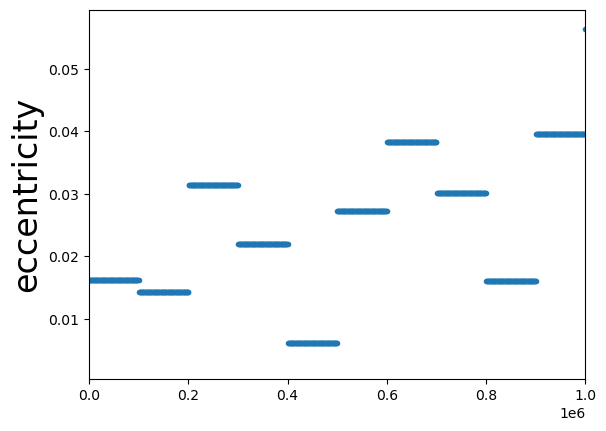

In [56]:
plt.plot(times, es, '.')
plt.ylabel("eccentricity", fontsize=24)
plt.xlim(0e6,1e6)
plt.show()

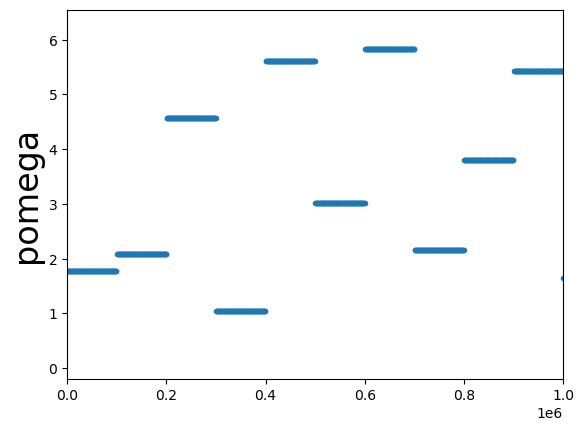

In [57]:
plt.plot(times, ps, '.')
plt.ylabel("pomega", fontsize=24)
plt.xlim(0e6,1e6)
plt.show()

In [118]:
quad = rebound.Simulation()
quad.add('Sun', date=date, hash='sun')
quad.add('Mercury', date=date)
quad.add('Venus', date=date)
quad.add('Earth', date=date, hash='earth')
quad.add('Mars', date=date)
quad.add('Jupiter', date=date)
quad.add('Saturn', date=date)
quad.add('Uranus', date=date)
quad.add('Neptune', date=date)
quad.move_to_com()
quad.convert_particle_units('AU', 'year', 'Msun')
qps = quad.particles

Searching NASA Horizons for 'Sun'... 
Found: Sun (10) 
Searching NASA Horizons for 'Mercury'... 
Found: Mercury Barycenter (199) (chosen from query 'Mercury')
Searching NASA Horizons for 'Venus'... 
Found: Venus Barycenter (299) (chosen from query 'Venus')
Searching NASA Horizons for 'Earth'... 
Found: Earth-Moon Barycenter (3) (chosen from query 'Earth')
Searching NASA Horizons for 'Mars'... 
Found: Mars Barycenter (4) (chosen from query 'Mars')
Searching NASA Horizons for 'Jupiter'... 
Found: Jupiter Barycenter (5) (chosen from query 'Jupiter')
Searching NASA Horizons for 'Saturn'... 
Found: Saturn Barycenter (6) (chosen from query 'Saturn')
Searching NASA Horizons for 'Uranus'... 
Found: Uranus Barycenter (7) (chosen from query 'Uranus')
Searching NASA Horizons for 'Neptune'... 
Found: Neptune Barycenter (8) (chosen from query 'Neptune')


In [119]:
quad.integrator = "whfast"
quad.save_to_file("quad.bin", interval=1e2,delete_file=True)
quad.dt = (365.25*0.05)/365.25
quad.exit_min_distance = 1e-3 # ~4x the distance between the Earth and Moon.
quad.exit_max_distance = 1000. # 1000 AU, Unlikely that a planet is bound.

rebx = reboundx.Extras(quad)

cf = rebx.load_force("quadrupole")
rebx.add_force(cf)

earth_m = qps['earth'].m/1.012
f = 0.8525
mu_eff = f*(1*0.012*(earth_m)**2)/(1.012*earth_m)

A = -1 * 3 * quad.G * qps['sun'].m / (4 * qps['earth'].m)
R = 0.0025696

qps[1].params["Rcentral"] = R
qps[1].params["mu_effcentral"] = mu_eff

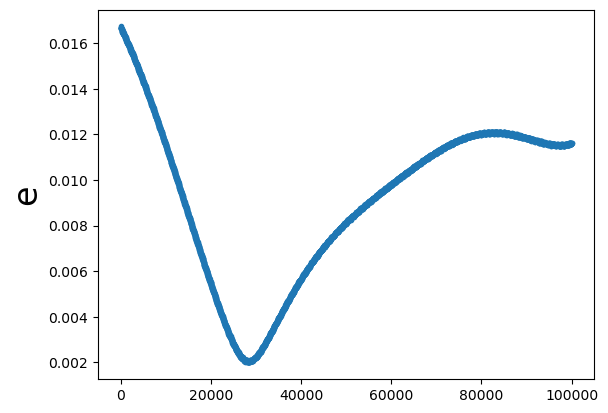

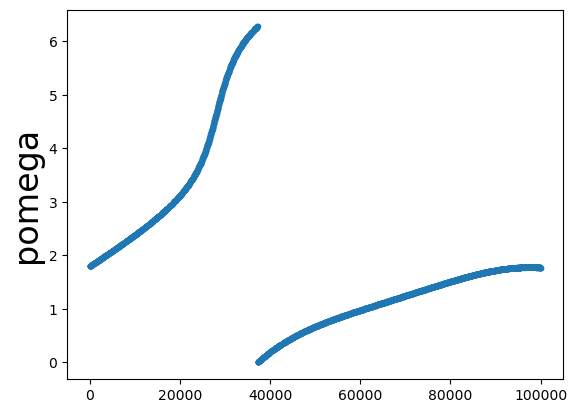

CPU times: user 4.54 s, sys: 24 ms, total: 4.56 s
Wall time: 4.56 s


In [120]:
%%time

# Nout = 5000
# eq, pomegaq = np.zeros(Nout), np.zeros(Nout)
# times = np.linspace(0,1e5,Nout)
# for i, time in enumerate(times):
#     quad.integrate(time)
#     eq[i] = qps['earth'].e
#     pomegaq[i] = qps['earth'].pomega
#     if pomegaq[i] < 0:
#         pomegaq[i] += 2*np.pi
#     quad.move_to_com()

quad.integrate(1e5)
    
# %matplotlib inline
# plt.plot(times, eq, '.')
# plt.ylabel("e", fontsize=24)
# plt.show()

# plt.plot(times, pomegaq, '.')
# plt.ylabel("pomega", fontsize=24)
# plt.show()

In [113]:
sa = rebound.Simulationarchive("quad.bin")
print("Number of snapshots: %d" % len(sa))
print("Time of first and last snapshot: %.1f, %.1f" % (sa.tmin, sa.tmax))

RuntimeError: Cannot read binary file. Check filename and file contents.

In [ ]:
def thread_init(*rest):
    global sat
    sat = rebound.Simulationarchive("quad.bin")
def analyze(t):
    sim = sat.getSimulation(t)
    e = sim.particles['earth'].e
    return e
with Pool(initializer=thread_init) as pool:
    times = np.linspace(sa.tmin, sa.tmax, 1000)
    es = pool.map(analyze,times)

In [ ]:
%matplotlib inline
plt.plot(times, eq, '.', label='Quad')
# plt.plot(times, e, '.', label='Resolved')
plt.ylabel("e", fontsize=24)
plt.xlim(6.1*1e6, 7.1*1e6)
plt.legend()
plt.show()

In [ ]:
%matplotlib inline
plt.plot(times, pomegaq, '.', label='Quad')
# plt.plot(times, pomega, '.', label='Resolved')
plt.ylabel("pomega", fontsize=24)
plt.xlim(6.1*1e6, 7.1*1e6)
plt.legend()
plt.show()